# Name: Ruta Misghina Gebremedhin
# ID: 500959486

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgba(229, 9, 9, 0.78);">
    <h1 style="font-weight: bold; font-size: 50px;">SVD++ Recommender System </h1>
</div>


In the notebook, we developed an SVD++ recommender system using MovieLens datasets. SVD++ is an advanced matrix factorization algorithm that improves upon standard SVD by incorporating implicit feedback—such as whether a user interacted with an item, even without rating it. This allows the model to better capture user preferences by factoring in both explicit ratings and underlying behavioral signals, making it especially effective in real-world recommendation scenarios with sparse data.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgba(229, 9, 9, 0.66);">
    <h1 style="font-weight: bold; font-size: 36px;">0. Importing Packages and Libraries</h1>
</div>


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from datetime import datetime, timedelta


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgba(229, 9, 9, 0.64);">
    <h1 style="font-weight: bold; font-size: 36px;">1.SVD++ using Netflix Dataset  </h1>
</div>


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:
rgba(151, 9, 9, 0.75);">
    <h1 style="font-weight: bold; font-size: 36px;">1.1 Preparing Set/Sample</h1>
</div>

Function to load the Movielens Dataset

In [2]:
def loadData(path):
    # Read as normal CSV (not "::" separated)
    df = pd.read_csv(path)

    # Rename to match standard format
    df = df.rename(columns={
        'CustomerID': 'user_id',
        'MovieID': 'item_id',
        'Rating': 'rating',
        'Date': 'timestamp'
    })

    # Keep only these four columns
    df = df[['user_id', 'item_id', 'rating', 'timestamp']]

    n_users = df['user_id'].nunique()
    n_items = df['item_id'].nunique()

    return df, n_users, n_items


In [ ]:
df, n_users, n_items = loadData(r'C:\Users\RUTA\Desktop\masters of digital driven bussines\SDM\SDM assigment\New folder\netflex\training_data.csv')

To ensure that the model has enough data to learn meaningful preferences:
- We **remove users** with fewer than 5 ratings because they don't provide enough signal to learn a reliable latent user vector.
- We **remove items** (movies) with fewer than 5 ratings because these are too rarely rated to generate meaningful latent features, increasing the risk of overfitting or noise.

In [4]:
# Filtering Out Inactive Users (Users with <5 ratings)
df = df[df["user_id"].map(df["user_id"].value_counts()) >= 5]

# Removing Rarely Rated Items (Movies with <5 ratings)
df = df[df["item_id"].map(df["item_id"].value_counts()) >= 5]


SVD++ can be computationally intensive on large datasets like Netflix.
To make experimentation faster and resource-efficient, we reduce the dataset size through **stratified sampling**:
- Rather than random sampling, we stratify based on the number of ratings per user to maintain the **distribution of user activity levels**.
- This ensures that the sampled dataset is still **representative** of the full dataset's user behavior patterns, which is critical for fair model evaluation. 
how we did the sampling is, We first measure user activity by counting how many ratings each user has given. Users are then grouped based on their activity level — active users (many ratings) and less active users (few ratings) are treated separately. During sampling, we preserve the original proportion of active and inactive users, ensuring that heavy raters remain equally represented. This maintains the natural rating patterns across popular and niche items. As a result, we obtain a much smaller, yet statistically representative dataset that allows faster model training without compromising behavioral realism.


This approach balances **efficiency** with **data integrity**, allowing quicker model iteration without compromising too much on performance fidelity.

In [5]:
from sklearn.model_selection import train_test_split

def stratified_sampling(df, sample_frac=0.01):
    """
    Performs stratified sampling to reduce dataset size while maintaining
    proportional representation of user activity levels.
    
    - `sample_frac`: Fraction of the dataset to keep (e.g., 0.1 for 10%)
    """
    # Step 1: Count number of ratings per user
    user_counts = df["user_id"].value_counts()

    # Step 2: Create a temporary column for stratification
    df["user_rating_count"] = df["user_id"].map(user_counts)

    # Step 3: Apply stratified sampling
    df_sampled, _ = train_test_split(df, test_size=(1 - sample_frac), stratify=df["user_rating_count"], random_state=42)

    # Step 4: Drop the temporary column
    df_sampled = df_sampled.drop(columns=["user_rating_count"])

    return df_sampled

# Apply stratified sampling (reduce dataset to 10%)
df_sampled = stratified_sampling(df, sample_frac=0.01)

# Print dataset sizes
print(f"Original dataset size: {len(df)}, Sampled dataset size: {len(df_sampled)}")


Original dataset size: 23889809, Sampled dataset size: 238898


In [6]:
# Count before sampling
num_users_before = df["user_id"].nunique()
num_items_before = df["item_id"].nunique()
# Count after sampling
num_users_after = df_sampled["user_id"].nunique()
num_items_after = df_sampled["item_id"].nunique()

# Print results
print(f" Before Sampling: Users = {num_users_before}, Items = {num_items_before}")
print(f" After Sampling: Users = {num_users_after}, Items = {num_items_after}")

 Before Sampling: Users = 405540, Items = 4498
 After Sampling: Users = 141095, Items = 4120


This function Splits the user-item matrix into train, validation, and test sets based on timestamp order. Ensures each user’s ratings are chronologically segmented (oldest 60% train, next 20% val, latest 20% test). Prevents data leakage by mimicking real-world temporal interactions. Crucial for time-aware recommendation evaluation.

In [7]:

# --------------------------- TIME-AWARE SPLITTING --------------------------- #
def time_aware_split(df):
   # df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')
    user_item_matrix = df.pivot(index="user_id", columns="item_id", values="rating")
    timestamp_matrix = df.pivot(index="user_id", columns="item_id", values="timestamp")

    train_matrix = user_item_matrix.copy(); train_matrix.loc[:, :] = np.nan
    val_matrix = user_item_matrix.copy(); val_matrix.loc[:, :] = np.nan
    test_matrix = user_item_matrix.copy(); test_matrix.loc[:, :] = np.nan

    for user in user_item_matrix.index:
        rated_items = user_item_matrix.loc[user].dropna().index
        timestamps = timestamp_matrix.loc[user, rated_items]
        sorted_items = timestamps.sort_values().index.tolist()
        n = len(sorted_items)

        if n < 5:
            continue  # not enough ratings to split meaningfully

        train_end = int(0.6 * n)
        val_end = int(0.8 * n)

        train_items = sorted_items[:train_end]
        val_items = sorted_items[train_end:val_end]
        test_items = sorted_items[val_end:]

        train_matrix.loc[user, train_items] = user_item_matrix.loc[user, train_items]
        val_matrix.loc[user, val_items] = user_item_matrix.loc[user, val_items]
        test_matrix.loc[user, test_items] = user_item_matrix.loc[user, test_items]

    return train_matrix, val_matrix, test_matrix



In [8]:
def index_matrix(matrix):
    """
    Converts a rating matrix into a binary indicator matrix (mask).
    Parameters:
        matrix (ndarray): Original user-item rating matrix.
    Returns:
        ndarray: Binary matrix where 1 = rated, 0 = not rated.
    Used to mask non-rated entries when computing evaluation metrics like RMSE.
    """
    I = matrix.copy()
    I[I > 0] = 1
    I[I == 0] = 0
    return I


def prediction(P, Q):
    """
    Computes the dot product between user and item latent vectors.
    Parameters:
        P (ndarray): User latent factor matrix (factors x users).
        Q (ndarray): Item latent factor matrix (factors x items).
    Returns:
        float: Predicted rating for a user-item pair.
    Core of the SVD prediction mechanism.
    """
    return np.dot(P.T, Q)


def rmse(I, R, item_by_users, avg, Q, P, Y, B_U, B_I):
    """
    Computes Root Mean Squared Error for SVD++ predictions.
    Parameters:
        I (ndarray): Binary matrix indicating rated entries.
        R (ndarray): Actual rating matrix.
        item_by_users (dict): Maps user index to list of rated item indices.
        avg (float): Global average rating.
        Q (ndarray): Item latent factor matrix.
        P (ndarray): User latent factor matrix.
        Y (ndarray): Implicit feedback latent matrix for items.
        B_U (ndarray): User bias vector.
        B_I (ndarray): Item bias vector.
    Returns:
        float: RMSE across all rated entries.
    """
    users, items = R.nonzero()
    error_sum = 0
    count = 0
    for u, i in zip(users, items):
        n_u = len(item_by_users.get(u, []))
        if n_u == 0:
            continue
        # Compute p + implicit feedback from items user interacted with
        pPlusY = P[:, u] + (1 / np.sqrt(n_u)) * np.sum(Y[item_by_users[u]], axis=0)
        pred = avg + B_U[u] + B_I[i] + prediction(pPlusY, Q[:, i])
        err = R[u, i] - pred
        error_sum += err ** 2
        count += 1
    return np.sqrt(error_sum / count) if count > 0 else np.nan


def plot_learning_curve(train_errors, val_errors, best_params):
    """
    Plots the RMSE learning curves for training and validation sets over epochs.
    Parameters:
        train_errors (list): RMSE values on training set per epoch.
        val_errors (list): RMSE values on validation set per epoch.
        best_params (dict): Best hyperparameters used (e.g., factors, gamma, reg).
    Visualization tool for monitoring convergence and overfitting.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_errors, label='Train RMSE')
    plt.plot(val_errors, label='Val RMSE')
    plt.title(f"Learning Curve (f={best_params['factors']}, γ={best_params['gamma']}, λ={best_params['reg']})")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgba(229, 9, 9, 0.61);">
    <h1 style="font-weight: bold; font-size: 36px;">1.3 Implicit Feedback Addition</h1>
</div>



## Integrating Explicit and Implicit Feedback in Recommender Systems

As stated earlier, a key goal of this work is to develop models that integrate both **explicit and implicit user feedback**.  
In datasets like Movielens Netflix, the ideal implicit signal would be **movie viewing history**, revealing user preferences without requiring explicit ratings. While such data isn't available, a subtle but useful proxy exists.

The dataset not only provides rating values but also shows **which movies users chose to rate**.  
This implies the user **watched the movie** and then decided to express an opinion—whether positive or negative.  
Conversely, if a user didn’t rate a movie, we can reasonably assume they **did not watch it**.

This transforms the ratings matrix into a **binary implicit feedback matrix** where:
- `1` = user watched and rated the item  
- `0` = user did not watch (and therefore did not rate) the item  

Although this form of implicit feedback is limited, it still reflects real interaction behavior.  
Incorporating this implicit signal into the model significantly improves prediction accuracy, making it a valuable component in any rating-based recommender system.




We have implemented our SVD++ recommender system based on the following paper, which formally introduces the mathematical foundations of matrix factorization techniques for recommender systems:

> **Yehuda Koren (2008).** *Factorization Meets the Neighborhood: A Multifaceted Collaborative Filtering Model*  
> [Link to paper](https://people.engr.tamu.edu/huangrh/Spring16/papers_course/matrix_factorization.pdf)

The formula we used in our model aligns with the SVD++ objective function proposed in this paper, incorporating both **explicit ratings** and **implicit feedback** to improve recommendation accuracy.


The model is trained by minimizing the following regularized loss function:

$$
\min_{p_u, q_i, y_j, b_u, b_i} \sum_{(u,i) \in \mathcal{K}} \left( r_{ui} - \mu - b_u - b_i - q_i^\top \left( p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in N(u)} y_j \right) \right)^2 + \lambda \left( \|p_u\|^2 + \|q_i\|^2 + \sum_{j \in N(u)} \|y_j\|^2 + b_u^2 + b_i^2 \right)
$$

**Where:**
- \( r_{ui} \): observed rating for user \( u \) and item \( i \)  
- \( \mu \): global average rating  
- \( b_u \), \( b_i \): user and item biases  
- \( p_u \), \( q_i \): user and item latent factor vectors  
- \( y_j \): implicit feedback vector for item \( j \in N(u) \)  
- \( N(u) \): set of items rated (watched) by user \( u \)  
- \( \mathcal{K} \): set of all user–item pairs with known ratings  
- \( \lambda \): regularization parameter

#### This Function below train_svdpp() is for Training an SVD++ model on explicit ratings while incorporating implicit feedback.

In [9]:
def train_svdpp(train_matrix, val_matrix, numFactors=20, gamma=0.01, reg=0.1,
                num_epochs=100, patience=5, verbose=False):
    """
    Trains an SVD++ model on explicit ratings while incorporating implicit feedback.
    
    Parameters:
        train_matrix (DataFrame): User-item rating matrix for training (with timestamps considered).
        val_matrix (DataFrame): Validation matrix for early stopping and performance tracking.
        numFactors (int): Number of latent factors for user/item representations.
        gamma (float): Learning rate for SGD.
        reg (float): Regularization strength to prevent overfitting.
        num_epochs (int): Max number of training iterations.
        patience (int): Number of epochs to wait for improvement before early stopping.
        verbose (bool): Whether to print progress logs.

    Returns:
        train_errors (list): RMSE per epoch on training set.
        val_errors (list): RMSE per epoch on validation set.
        best_model (tuple): Tuple of final model parameters (P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map).
    """

    # Setup: Extract user/item indices and map to internal IDs
    users = train_matrix.index.tolist()
    items = train_matrix.columns.tolist()
    user_map = {u: i for i, u in enumerate(users)}
    item_map = {v: j for j, v in enumerate(items)}
    n_users, n_items = len(users), len(items)

    # Convert rating matrices to numpy arrays, filling missing ratings with 0
    R = train_matrix.fillna(0).values
    V = val_matrix.fillna(0).values
    avg = R[R > 0].mean()  # Global average rating

    # Dictionary: For each user, store the list of items they rated (used for implicit signal)
    item_by_users = {u: list(np.where(R[u] > 0)[0]) for u in range(n_users)}

    # Create binary indicator masks for evaluation
    I = index_matrix(R)
    I_val = index_matrix(V)

    # Initialize latent factor matrices and bias terms
    P = np.random.normal(scale=0.1, size=(numFactors, n_users))   # User factors
    Q = np.random.normal(scale=0.1, size=(numFactors, n_items))   # Item factors
    Y = np.random.normal(scale=0.1, size=(n_items, numFactors))   # Implicit feedback item factors
    B_U = np.zeros(n_users)  # User bias
    B_I = np.zeros(n_items)  # Item bias

    train_errors = []
    val_errors = []
    best_val_rmse = float("inf")
    best_epoch = 0
    best_model_snapshot = None

    # ---------- Training Loop ---------- #
    for epoch in range(num_epochs):
        for u in range(n_users):
            for i in item_by_users[u]:
                n_u = len(item_by_users[u])
                if n_u == 0:
                    continue

                # Compute user representation: explicit + implicit (Y)
                pPlusY = P[:, u] + (1 / np.sqrt(n_u)) * np.sum(Y[item_by_users[u]], axis=0)

                # Predict rating and compute error
                err = R[u, i] - (avg + B_U[u] + B_I[i] + prediction(pPlusY, Q[:, i]))

                # Gradient Descent Updates
                P[:, u] += gamma * (err * Q[:, i] - reg * P[:, u])
                Q[:, i] += gamma * (err * pPlusY - reg * Q[:, i])
                for j in item_by_users[u]:
                    Y[j, :] += gamma * (err * (1 / np.sqrt(n_u)) * Q[:, i] - reg * Y[j, :])
                B_U[u] += gamma * (err - reg * B_U[u])
                B_I[i] += gamma * (err - reg * B_I[i])

        # Evaluate model using RMSE
        train_rmse = rmse(I, R, item_by_users, avg, Q, P, Y, B_U, B_I)
        val_rmse = rmse(I_val, V, item_by_users, avg, Q, P, Y, B_U, B_I)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)

        # Optional log printing
        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} - Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

        # Early stopping: Track best model snapshot
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_epoch = epoch
            best_model_snapshot = (P.copy(), Q.copy(), Y.copy(), B_U.copy(), B_I.copy())
        elif epoch - best_epoch >= patience:
            if verbose:
                print(f" Early stopping at epoch {epoch+1}")
            break

    # Load best-performing model
    P, Q, Y, B_U, B_I = best_model_snapshot

    return train_errors, val_errors, (P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map)


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgba(229, 9, 27, 0.54);">
    <h1 style="font-weight: bold; font-size: 36px;">1.4 hyperparameter Tuning</h1>
</div>



This function is used for hyperparameter tuning of the SVD++ model, using time-aware splitting to optimize performance on future data.

In [10]:
from itertools import product


def run_hyperparameter_search(df_sampled):
    """
    Performs grid search over hyperparameters for the SVD++ model using time-aware splitting.
    
    Parameters:
        df_sampled (DataFrame): Preprocessed interaction dataset with columns ['user_id', 'item_id', 'rating', 'timestamp'].
    
    Returns:
        best_model (tuple): Trained model parameters (P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map).
        train_val_matrix (DataFrame): Combined train and validation matrix used for final test evaluation.
    """
    
    # Step 1: Split the data into train, validation, and test using time-aware chronological splitting
    print("Splitting data...")
    train_matrix, val_matrix, test_matrix = time_aware_split(df_sampled.copy())

    # Step 2: Define the hyperparameter search space
    factor_list = [10, 20]       # Latent factor dimensions
    gamma_list = [0.01, 0.005]       # Learning rates
    reg_list = [0.05, 0.1]           # Regularization strengths

    # Step 3: Initialize tracking variables for best model
    best_score = float("inf")
    best_model = None
    best_params = {}
    best_train_errors = []
    best_val_errors = []

    # Step 4: Grid search over all (factors, gamma, reg) combinations
    for f, g, r in product(factor_list, gamma_list, reg_list):
        print(f"\n Tuning: numFactors={f}, gamma={g}, reg={r}")
        
        # Train SVD++ model with current hyperparameters
        train_rmse, val_rmse, model = train_svdpp(train_matrix, val_matrix,
                                                  numFactors=f, gamma=g, reg=r,
                                                  num_epochs=100, patience=5,
                                                  verbose=False)
        # Step 5: Track the model with lowest validation RMSE
        if val_rmse[-1] < best_score:
            best_score = val_rmse[-1]
            best_params = {"factors": f, "gamma": g, "reg": r}
            best_model = model
            best_train_errors = train_rmse
            best_val_errors = val_rmse

    # Step 6: Report the best parameters and plot the learning curve
    print("\n Best Hyperparameters Found:")
    print(best_params)
    print(f"Best Validation RMSE: {best_score:.4f}")
    plot_learning_curve(best_train_errors, best_val_errors, best_params)

    # Step 7: Final model evaluation on the test set
    print("\n Final Test Evaluation...")
    
    # Merge train and validation for final test evaluation
    train_val_matrix = train_matrix.combine_first(val_matrix)
    
    # Prepare test matrix and mask
    R_test = test_matrix.fillna(0).values
    I_test = index_matrix(R_test)

    # Unpack model parameters
    P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map = best_model

    # Evaluate test RMSE
    test_rmse = rmse(I_test, R_test, item_by_users, avg, Q, P, Y, B_U, B_I)
    print(f"Final Test RMSE: {test_rmse:.4f}")

    return best_model, train_val_matrix, test_matrix



<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgba(229, 9, 20, 0.56);">
    <h1 style="font-weight: bold; font-size: 36px;">1.5 Recommender System</h1>
</div>



This function recommends the top-3 movies that a user has not interacted with or rated, meaning they likely haven't watched them. Using a trained SVD++ model, it builds the user's latent profile, predicts ratings for all unseen movies, and returns the top-3 with the highest predicted scores as personalized recommendations.

In [11]:
def recommend_top3_for_user(user_id, model, train_val_matrix):
    """
    Recommend top-3 movies the user hasn't rated yet, using a trained SVD++ model.
    
    Args:
        user_id (int): Original MovieLens user ID
        model (tuple): Trained model returned from train_svdpp(...)
        train_val_matrix (pd.DataFrame): Matrix of known ratings (train + val)
    
    Returns:
        List of (item_id, predicted_rating) tuples, top-3 recommendations
    """
    P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map = model

    if user_id not in user_map:
        print(f"User {user_id} is not in the training data.")
        return []

    user_index = user_map[user_id]
    n_u = len(item_by_users.get(user_index, []))
    if n_u == 0:
        print(f"User {user_id} has no rated items in the training set.")
        return []

    # Create user representation vector
    pPlusY = P[:, user_index] + (1 / np.sqrt(n_u)) * np.sum(Y[item_by_users[user_index]], axis=0)

    # Identify unseen items
    seen_items = set(np.where(train_val_matrix.loc[user_id].fillna(0).values > 0)[0])
    all_items = set(range(Q.shape[1]))
    unseen_items = list(all_items - seen_items)

    # Predict scores for unseen items
    reverse_item_map = {v: k for k, v in item_map.items()}
    predictions = []
    for i in unseen_items:
        pred_score = avg + B_U[user_index] + B_I[i] + prediction(pPlusY, Q[:, i])
        predictions.append((reverse_item_map[i], round(pred_score, 3)))

    # Return top 3
    return sorted(predictions, key=lambda x: x[1], reverse=True)[:3]


This is the main execution block that loads the dataset, runs the full SVD++ training pipeline with hyperparameter tuning, and returns the best model along with the train-validation matrix for generating recommendations.

Splitting data...

 Tuning: numFactors=10, gamma=0.01, reg=0.05

 Tuning: numFactors=10, gamma=0.01, reg=0.1

 Tuning: numFactors=10, gamma=0.005, reg=0.05

 Tuning: numFactors=10, gamma=0.005, reg=0.1

 Tuning: numFactors=20, gamma=0.01, reg=0.05

 Tuning: numFactors=20, gamma=0.01, reg=0.1

 Tuning: numFactors=20, gamma=0.005, reg=0.05

 Tuning: numFactors=20, gamma=0.005, reg=0.1

 Best Hyperparameters Found:
{'factors': 10, 'gamma': 0.01, 'reg': 0.1}
Best Validation RMSE: 0.9876


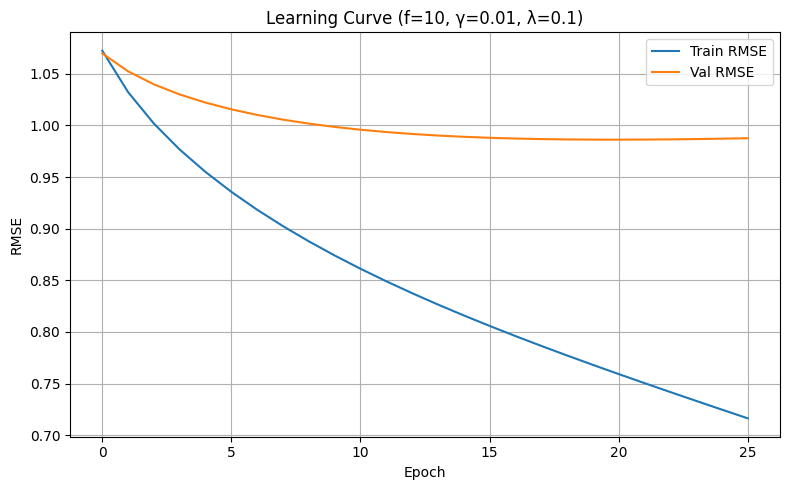


 Final Test Evaluation...
Final Test RMSE: 1.0062


In [12]:
# --------------------------- MAIN BLOCK --------------------------- #
if __name__ == "__main__":
    # Load MovieLens 100k data
    df_sampled = df_sampled

    # Run full SVD++ pipeline with tuning and recommendation
    best_model, train_val_matrix, test_matrix = run_hyperparameter_search(df_sampled)


In [ ]:
import pandas as pd

movies_path = r'C:\Users\RUTA\Desktop\masters of digital driven bussines\SDM\SDM assigment\New folder\netflex\movie_titles.csv'

def load_netflix_titles(path):
    rows = []
    with open(path, encoding="ISO-8859-1") as f:
        for line in f:
            parts = line.strip().split(",", 2)  # Split on first two commas only
            if len(parts) == 3:
                movie_id, year, title = parts
                # Skip rows with non-numeric IDs or years
                if not movie_id.isdigit() or not year.isdigit():
                    print(f"Skipping row with invalid data: {line.strip()}")
                    continue
                rows.append((int(movie_id), int(year), title))
            else:
                print(f"Skipping malformed line: {line.strip()}")
    return pd.DataFrame(rows, columns=["movie_id", "year", "movieTitle"])

movies_df = load_netflix_titles(movies_path)

Skipping row with invalid data: 4388,NULL,Ancient Civilizations: Rome and Pompeii
Skipping row with invalid data: 4794,NULL,Ancient Civilizations: Land of the Pharaohs
Skipping row with invalid data: 7241,NULL,Ancient Civilizations: Athens and Greece
Skipping row with invalid data: 10782,NULL,Roti Kapada Aur Makaan
Skipping row with invalid data: 15918,NULL,Hote Hote Pyaar Ho Gaya
Skipping row with invalid data: 16678,NULL,Jimmy Hollywood
Skipping row with invalid data: 17667,NULL,Eros Dance Dhamaka


In [14]:
# Rename 'movie_id' in movies_df to match 'item_id' from df_sampled
movies_df_renamed = movies_df.rename(columns={"movie_id": "item_id"})

# Step 2: Perform the inner merge
merged_df = pd.merge(df_sampled, movies_df_renamed, on="item_id", how="inner")

# Step 3: Preview result
merged_df.head()


,user_id,item_id,rating,timestamp,year,movieTitle
0,1889884,1145,2,2004-02-28,2001,The Wedding Planner
1,977002,3858,2,2001-10-24,2001,Sugar & Spice
2,542919,4260,3,2002-05-30,2001,Rat Race
3,2429347,1428,2,2005-10-07,2003,The Recruit
4,1482177,3851,5,2005-12-14,1992,Inspector Morse 25: Cherubim & Seraphim


Generate Recomendation 

In [15]:
user_id = 1664010  # or any user_id from your dataset
top3 = recommend_top3_for_user(user_id, best_model, train_val_matrix)

print(f"\nTop-3 recommendations for user {user_id}:\n")
for item_id, predicted_rating in top3:
    title = movies_df.loc[movies_df["movie_id"] == item_id, "movieTitle"].values
    title_str = title[0] if len(title) > 0 else "Unknown Title"
    print(f"{title_str} → Predicted rating: {predicted_rating}")



Top-3 recommendations for user 1664010:

Finding Nemo (Widescreen) → Predicted rating: 5.046
The Simpsons: Treehouse of Horror → Predicted rating: 5.005
Lord of the Rings: The Fellowship of the Ring → Predicted rating: 4.974


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgb(143, 16, 16);">
    <h1 style="font-weight: bold; font-size: 36px;">1.6 Evaluating the Recommended Items</h1>
</div>



We begin by evaluating the recommender system’s effectiveness using precision (or hit rate). A precision of zero in this context is desirable, as it indicates that the system is not recommending any movies the user has already seen. Instead, it exclusively suggests unseen items, aligning with our goal. As shown below, the hit rate is zero, which confirms that the recommender is performing as intended.

In [26]:
# ----------- Manual Precision@3 Calculation for a Specific User ----------- #

user_id = 1664010   # Change this to any valid user in your dataset
k = 3         # Top-K recommendation

# Step 1: Generate top-K recommendations
top_k_recs = recommend_top3_for_user(user_id, best_model, train_val_matrix)
recommended_items = [item_id for item_id, _ in top_k_recs]

# Step 2: Get the ground truth items the user actually rated in the test set
ground_truth = test_matrix.loc[user_id].dropna().index.tolist()

# Step 3: Calculate hits and compute Precision@K
hits = sum(1 for item in recommended_items[:k] if item in ground_truth)
precision = hits/k

# Step 4: Output
print(f"Top-{k} recommended items for user {user_id}: {recommended_items}")
print(f"Ground truth rated items in test set: {ground_truth}")
print(f"Hits: {hits} out of {k}")
print(f"Precision@{k} for user {user_id}: {precision:.4f}")

Top-3 recommended items for user 1664010: [3962, 3046, 2452]
Ground truth rated items in test set: [259, 657, 732, 2822, 3128, 3535, 3942, 4258]
Hits: 0 out of 3
Precision@3 for user 1664010: 0.0000


### In addition to precision, we evaluate the recommender system using two complementary metrics: **novelty** and **diversity**, both computed at Top-K (K=3) recommendations.



This code loads the MovieLens movies dataset and extracts structured information about each movie’s genre. It first identifies all unique genre types present in the dataset, then creates a one-hot encoded vector for each movie based on its genre tags. These vectors are used to build a `movie_features_dict`, which maps each movie ID to its corresponding genre-based feature representation. This structured mapping is essential for computing similarity-based metrics such as diversity in recommendation evaluation.


In [27]:
import numpy as np

# Step 1: Identify all unique years (sorted)
all_years = sorted(movies_df["year"].unique())

# Step 2: Create a one-hot encoded vector per year
def encode_year(year, year_list):
    year_vector = np.zeros(len(year_list))
    if year in year_list:
        idx = year_list.index(year)
        year_vector[idx] = 1
    return year_vector

# Step 3: Build the feature dictionary (year-based)
movie_year_features_dict = {}
for row in movies_df.itertuples(index=False):
    movie_year_features_dict[row.movie_id] = encode_year(row.year, all_years)

# Done
print(f"Loaded year features for {len(movie_year_features_dict)} movies.")


Loaded year features for 17763 movies.


#### Novelty

**Novelty** quantifies how *unfamiliar* the recommended items are to the user. We compute it by applying an inverse log-scaled popularity measure for each recommended item, where item popularity is derived from the training and validation data:

`novelty = -log₂(popularity + 1)`

Less popular items yield higher novelty scores. This encourages the system to recommend content that users are less likely to have encountered through mainstream exposure, thereby promoting discovery and exploration.

#### Diversity

**Diversity** measures how *different* the recommended items are from one another. We compute this by:

1. Representing each movie as a one-hot encoded genre vector.
2. Calculating pairwise cosine similarity among the Top-K recommended items.
3. Averaging these similarities (excluding self-similarity).
4. Defining diversity as:

`diversity = 1 - average_pairwise_similarity`

Higher diversity scores indicate that the recommended items span a broader range of themes or genres, minimizing redundancy and enhancing the user's engagement with varied content.

These metrics are averaged across all users with valid test interactions to yield a system-level evaluation. This enables a more comprehensive assessment, capturing not just the **accuracy** of recommendations but also their **novelty** and **diversity** — two essential properties for a robust and user-centered recommender system.


In [40]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Create item popularity from training+validation data
item_popularity = train_val_matrix.notna().sum().to_dict()
def novelty_at_k(recommended_items, item_popularity, k=3):
    total = 0
    for item in recommended_items[:k]:
        pop = item_popularity.get(item, 1)  # avoid division by zero
        total += -np.log2(pop + 1)
    return total / k

def diversity_from_ratings(user_item_matrix, item_indices, k=10):
    item_vectors = []
    for col_idx in item_indices[:k]:
        vector = user_item_matrix[:, col_idx].toarray().flatten()
        item_vectors.append(vector)

    item_vectors = [v for v in item_vectors if np.any(v)]
    if len(item_vectors) < 2:
        return 0

    sim_matrix = cosine_similarity(item_vectors)
    n = len(sim_matrix)
    total_sim = np.sum(sim_matrix) - np.trace(sim_matrix)
    avg_sim = total_sim / (n * (n - 1))
    return 1 - avg_sim



In [41]:
def evaluate_all_metrics(
    test_matrix,
    best_model,
    train_val_matrix,
    item_popularity,
    user_item_matrix,  # Pass it in
    k=3
):
    P, Q, Y, B_U, B_I, avg, item_by_users, user_map, item_map = best_model
    reverse_item_map = {v: k for k, v in item_map.items()}

    novelties, diversities = [], []
    valid_users = 0

    for user_id in test_matrix.index:
        if user_id not in user_map:
            continue

        user_index = user_map[user_id]
        n_u = len(item_by_users.get(user_index, []))
        if n_u == 0:
            continue

        # Build user vector
        pPlusY = P[:, user_index] + (1 / np.sqrt(n_u)) * np.sum(Y[item_by_users[user_index]], axis=0)

        # Identify unseen items
        seen_items = set(np.where(train_val_matrix.loc[user_id].notna())[0])
        all_items = set(range(Q.shape[1]))
        unseen_items = list(all_items - seen_items)

        # Predict and get top-k
        predictions = []
        for i in unseen_items:
            pred_score = avg + B_U[user_index] + B_I[i] + np.dot(pPlusY, Q[:, i])
            predictions.append((reverse_item_map[i], pred_score))

        top_k = sorted(predictions, key=lambda x: x[1], reverse=True)[:k]
        recommended_ids = [item_id for item_id, _ in top_k]

        recommended_internal_indices = [item_map[orig_id] for orig_id in recommended_ids]


        # Check ground truth in test set
        ground_truth = test_matrix.loc[user_id].dropna().index.tolist()
        if not ground_truth:
            continue

        # Compute novelty
        novelties.append(novelty_at_k(recommended_ids, item_popularity, k))

        # Compute diversity
        diversities.append(diversity_from_ratings(user_item_matrix, recommended_internal_indices, k))

        valid_users += 1

    return {
        "Novelty": np.mean(novelties),
        "Diversity": np.mean(diversities),
        "Users Evaluated": valid_users
    }

In [34]:
from scipy.sparse import csr_matrix
user_item_matrix = csr_matrix(train_val_matrix.fillna(0).values)

In [42]:
# Then call evaluate_all_metrics
metrics = evaluate_all_metrics(
    test_matrix=test_matrix,
    best_model=best_model,
    train_val_matrix=train_val_matrix,
    item_popularity=item_popularity,
    user_item_matrix=user_item_matrix,  # pass it in
    k=3
)

print("Evaluation Metrics (Top-3 Recommendations):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics (Top-3 Recommendations):
Novelty: -5.0628
Diversity: 0.9904
Users Evaluated: 4967.0000


### Novelty: -4.7060
The novelty score is negative, as expected, because it's based on the formula `-log₂(popularity + 1)`. A score of **-4.71** suggests that the system is generally recommending **moderately popular items** — not the most mainstream, but not obscure either.Lower (more negative) values indicate recommendations skewing toward more popular items. To increase novelty (i.e., recommend less well-known content), the system would need to shift toward **lower-popularity** items in its top-K suggestions.
### Diversity: 0.8089

This is a **strong diversity score** on a 0–1 scale.  
A score of **0.81** implies that the recommended items for each user are **highly dissimilar** in terms of their genre composition.  
This reflects a healthy level of **variety** in the top-3 recommendations, reducing redundancy and increasing the likelihood that users will find something novel or unexpected within each set.
